In [1]:
! head ../tests/data/*

==> ../tests/data/settings.toml <==
[tdf_config]
SCAN_MODE = 9
MZ_MIN = 300.0
MZ_MAX = 1600.0
NUM_TOF_BINS = 638426
IM_MIN = 0.64
IM_MAX = 1.45
NUM_SCANS = 702
ACCUMULATION_TIME = 75
RAMP_TIME = 75

==> ../tests/data/transitions.json <==
[
  {
    "ms1_mz": 654.32,
    "ms1_charge": 2,
    "ms1_intensity": 10000,
    "apex_ims": 0.9,
    "ims_fwhm": 0.05,
    "apex_time": 300.5,
    "time_fwhm": 2.0,
    "ms2_mzs": [ 300, 400, 500, 998.5 ],


In [2]:
! python -m tdf_simulator.random --output_file mysupercoolfile_random.d --config_file ../tests/data/settings.toml --num_transitions 200000    

2024-08-23 22:07:50.539 | INFO     | tdf_simulator.converters:from_params:58 - Starting SpecConverter, with slope: -0.0011538461538461537, intercept: 1.45
2024-08-23 22:07:50.539 | INFO     | tdf_simulator.converters:new:104 - Starting Tof2MzConverter, with slope: 3.552407314913745e-05, intercept: 17.320508075688775
2024-08-23 22:07:51.660 | INFO     | tdf_simulator.simulator:report_start:169 - Generating TDF data
2024-08-23 22:07:51.660 | INFO     | tdf_simulator.simulator:report_start:170 - TDF Config: TDFConfig(SCAN_MODE=9, MZ_MIN=300.0, MZ_MAX=1600.0, NUM_TOF_BINS=638426, IM_MIN=0.64, IM_MAX=1.45, NUM_SCANS=702, ACCUMULATION_TIME=75, RAMP_TIME=75)
2024-08-23 22:07:51.660 | INFO     | tdf_simulator.simulator:report_start:171 - Run Config: RunConfig(num_cycles=1866.0, frames_per_cycle=9, num_dia_window_groups=8, scan_groups_per_window_group=3)
2024-08-23 22:07:51.671 | INFO     | tdf_simulator.simulator:report_frame_expects:175 - Frames template:
2024-08-23 22:07:51.678 | INFO     | 

In [3]:
! du -sh mysupercoolfile_random.d/*

960K	mysupercoolfile_random.d/analysis.tdf
240M	mysupercoolfile_random.d/analysis.tdf_bin


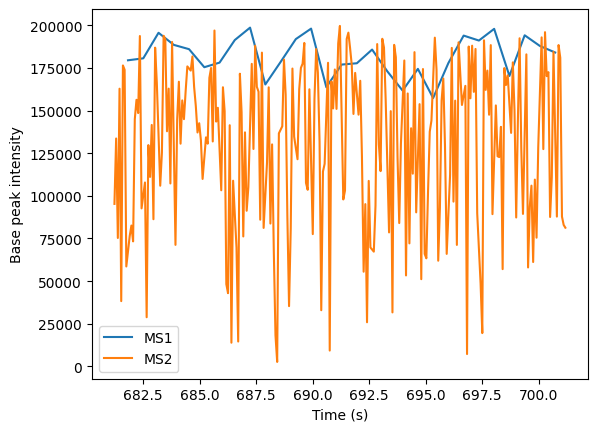

In [4]:
import numpy as np
import timsrust_pyo3
from matplotlib import pyplot as plt

reader = timsrust_pyo3.TimsReader("mysupercoolfile_random.d")
all_frames = timsrust_pyo3.read_all_frames("mysupercoolfile_random.d")
tic = np.array([sum(x.intensities) for x in all_frames])
bpc = np.array([max(x.intensities) if x.intensities else 0 for x in all_frames])

apex = np.argmax(bpc)
time = np.array([x.rt for x in all_frames])
types = np.array([x.frame_type for x in all_frames])
left = np.searchsorted(time, all_frames[apex].rt - 10)
right = np.searchsorted(time, all_frames[apex].rt + 10)

times = time[left:right]
types = types[left:right]

ms1s = bpc[left:right][types == 0]
ms1_times = time[left:right][types == 0]
ms2s = bpc[left:right][types == 2]
ms2_times = time[left:right][types == 2]


plt.plot(ms1_times, ms1s, label="MS1")
plt.plot(ms2_times, ms2s, label="MS2")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Base peak intensity")
plt.show()

In [5]:
frame_at_apex = all_frames[apex]
frame_at_apex

PyFrame(index=9216, rt=691.1999999999999, frame_type=2, len(scan_offsets)=703, len(tof_indices)=4412, len(intensities)=4412)

Text(0, 0.5, 'scan_index')

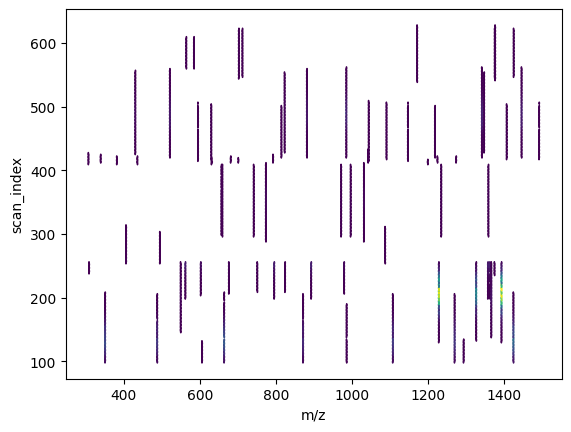

In [6]:
def make_2d_array(x, y, z):
    out = np.zeros((x.max() + 1, y.max() + 1))
    out[x, y] = z
    return out


xs = np.array(frame_at_apex.tof_indices)
# ys = np.array(frame_at_apex.scan)

imss = []
tmp = frame_at_apex.scan_offsets
for i in range(len(tmp) - 1):
    imss.extend([i] * (tmp[i + 1] - tmp[i]))

imss = np.array(imss)

# plt.imshow(make_2d_array(xs, imss, frame_at_apex.intensities), aspect="auto")
plt.hexbin(
    reader.resolve_mzs(xs),
    imss,
    gridsize=(1000, 100),
    C=frame_at_apex.intensities,
    cmap="viridis",
)
plt.xlabel("m/z")
plt.ylabel("scan_index")

Text(0, 0.5, 'scan index')

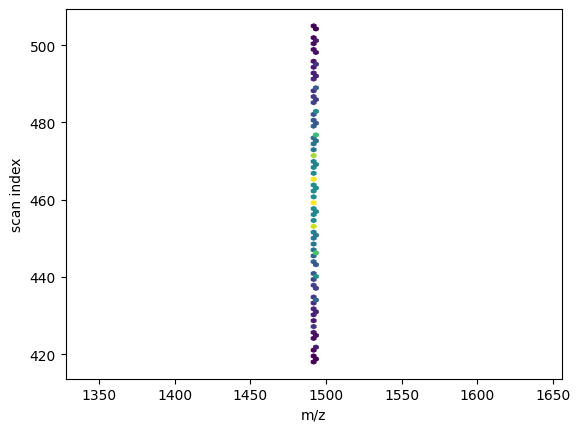

In [7]:
max_x = xs.max()
mask = (xs > (max_x - 2000)) & (xs < (max_x + 2000))
ints = np.array(frame_at_apex.intensities)

plt.hexbin(reader.resolve_mzs(xs[mask]), imss[mask], C=ints[mask], cmap="viridis")
plt.xlabel("m/z")
plt.ylabel("scan index")
# np.unique(xs[mask], return_inverse=True)